In [371]:
%load_ext autoreload
%autoreload 2
from cmip6_downscaling.methods.common.utils import zmetadata_exists
from upath import UPath
import xarray as xr
from cmip6_downscaling.methods.common.bias_correction import (
    bias_correct_obs_by_method,
    bias_correct_gcm_by_method,
)
from cmip6_downscaling.methods.common.tasks import make_run_parameters

# from cmip6_downscaling.data.observations import open_era5
# from cmip6_downscaling.methods.bcsd.tasks import fit_and_predict
import os
import fsspec
import rechunker
import zarr
from sklearn.exceptions import DataConversionWarning
import warnings
import sklearn
import dask
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

connection_string = os.environ.get("AZURE_STORAGE_CONNECTION_STRING")
fs = fsspec.filesystem('az', connection_string=connection_string)
from skdownscale.pointwise_models import (
    PointWiseDownscaler,
    QuantileMappingReressor,
    TrendAwareQuantileMappingRegressor,
)
from cmip6_downscaling.methods.gard.tasks import _fit_and_predict_wrapper
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from cmip6_downscaling.methods.common.bias_correction import (
    bias_correct_gcm_by_method,
    bias_correct_obs_by_method,
)
from cmip6_downscaling.methods.gard.utils import get_gard_model, read_scrf
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 251.72 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33811,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 251.72 GiB
Comm: tcp://127.0.0.1:33717,Total threads: 4
Dashboard: http://127.0.0.1:39545/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:33357,


In [2]:
# /srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:993:

In [298]:
def plot_cdf(da, label=''):
    # getting data of the histogram
    if isinstance(da, xr.DataArray):
        count, bins_count = np.histogram(da, bins=len(da.time))
    else:
        count, bins_count = np.histogram(da, bins=1000)
    # using numpy np.cumsum to calculate the CDF
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    # plotting PDF and CDF
    plt.plot(bins_count[1:], cdf, label=label)
    plt.legend()

In [ ]:
run_parameters = {
    'method': 'gard',
    'obs': 'ERA5',
    'model': 'MIROC6',
    'scenario': 'ssp370',
    'grid_label': 'gn',
    'table_id': 'day',
    'member': 'r1i1p1f1',
    'features': ['tasmax'],
    'variable': 'tasmax',
    'train_period': ['1981', '2010'],
    'predict_period': ['1981', '2010'],
    'latmin': '-90',
    'latmax': '90',
    'lonmin': '-180',
    'lonmax': '180',
    'bias_correction_method': 'quantile_transform',
    'bias_correction_kwargs': {'output_distribution': 'normal'},
    'model_type': 'PureRegression',
    'model_params': {},
}

In [299]:
xtrain_path = 'az://flow-outputs/gard_test_intermediate/0.0.post580+dirty/rechunk/7db1175f3c48c391'
ytrain_path = 'az://flow-outputs/gard_test_intermediate/0.0.post580+dirty/rechunk/b370e4f278afb631'
xpred_path = 'az://flow-outputs/gard_test_intermediate/0.0.post580+dirty/rechunk/d1f4ba279426daef'
xhist_path = 'az://flow-outputs/gard_test_intermediate/0.0.post580+dirty/rechunk/2e6bea5743ea56d9'

In [300]:
region = {'lon': slice(-126, -116), 'lat': slice(42, 50)}

In [301]:
location = {'lat': 47.5, 'lon': -122.25}

In [465]:
xtrain = xr.open_zarr(xtrain_path).sel(**region).sel(**location).load()
ytrain = xr.open_zarr(ytrain_path).sel(**region).sel(**location).load()
xpred = xr.open_zarr(xhist_path).sel(**region).sel(**location).load()
xhist = xr.open_zarr(xhist_path).sel(**region).sel(**location).load()
scrf = read_scrf(run_parameters).sel(**region).sel(**location).load()

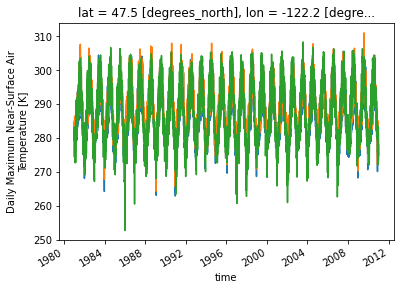

In [297]:
xtrain['tasmax'].plot()
ytrain['tasmax'].plot()
xpred['tasmax'].plot()

# We'll take it down to the basics and use the sklearn/skdownscale utilities

In [402]:
bc_kwargs = {'output_distribution': 'uniform', 'n_quantiles': len(xtrain.time)}
qt = QuantileTransformer(**bc_kwargs)
qt.fit(xtrain['tasmax'].drop(['lat', 'lon']).to_dataframe())
transformed_xtrain = qt.transform(xtrain['tasmax'].drop(['lat', 'lon']).to_dataframe())

Question: does the transformed data look like we'd expect? Yes it does! for both uniform and normal distributions.

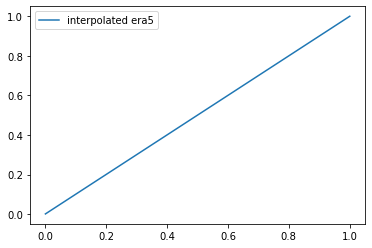

In [388]:
plot_cdf(transformed_xtrain, label='interpolated era5')

now let's compare the transformed xtrain with the actual era5

In [389]:
data = pd.DataFrame()
data['transformed_xtrain'] = transformed_xtrain.squeeze()
data['ytrain'] = ytrain['tasmax'].drop(['lat', 'lon']).to_dataframe()['tasmax'].values

<AxesSubplot:xlabel='transformed_xtrain', ylabel='ytrain'>

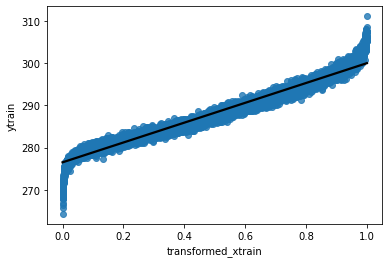

In [400]:
sns.regplot(x='transformed_xtrain', y='ytrain', data=data, line_kws={"color": "k"})

intuition of effect: predictions will be constrained on both high and low ends

In [391]:
uniform_model = get_gard_model('PureRegression', model_params={})
uniform_model.fit(
    transformed_xtrain, ytrain['tasmax'].drop(['lat', 'lon']).to_dataframe()['tasmax'].values
)

PureRegression()

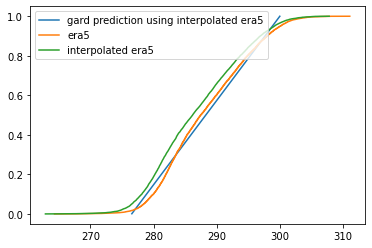

In [401]:
plot_cdf(
    uniform_model.predict(transformed_xtrain)[:, 0], label='gard prediction using interpolated era5'
)
plot_cdf(ytrain['tasmax'], label='era5')
plot_cdf(xtrain['tasmax'], label='interpolated era5')

# now let's try it with normal

In [424]:
bc_kwargs = {'output_distribution': 'normal', 'n_quantiles': len(xtrain.time)}
qt = QuantileTransformer(**bc_kwargs)
qt.fit(xtrain['tasmax'].drop(['lat', 'lon']).to_dataframe())
transformed_xtrain = qt.transform(xtrain['tasmax'].drop(['lat', 'lon']).to_dataframe())

<AxesSubplot:xlabel='transformed_xtrain', ylabel='ytrain'>

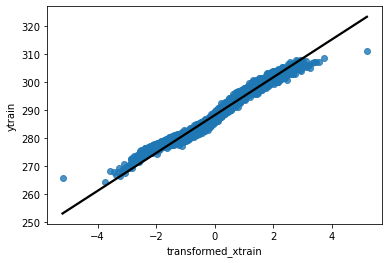

In [425]:
data = pd.DataFrame()
data['transformed_xtrain'] = transformed_xtrain.squeeze()
data['ytrain'] = ytrain['tasmax'].drop(['lat', 'lon']).to_dataframe()['tasmax'].values
sns.regplot(x='transformed_xtrain', y='ytrain', data=data, line_kws={"color": "k"})

intuitive effect: normal transformation will exaggerate the high end and low end.

In [411]:
normal_model = get_gard_model('PureRegression', model_params={})
normal_model.fit(
    transformed_xtrain, ytrain['tasmax'].drop(['lat', 'lon']).to_dataframe()['tasmax'].values
)

PureRegression()

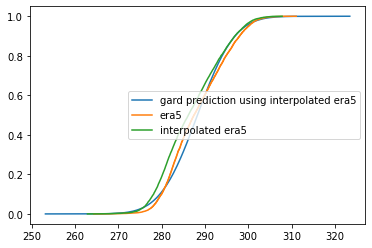

In [412]:
plot_cdf(
    normal_model.predict(transformed_xtrain)[:, 0], label='gard prediction using interpolated era5'
)
plot_cdf(ytrain['tasmax'], label='era5')
plot_cdf(xtrain['tasmax'], label='interpolated era5')

observation: in the middle it's more or less the same but tails are extended.

# let's try zscore

In [427]:
bc_kwargs = {}
ss = StandardScaler(**bc_kwargs)
ss.fit(xtrain['tasmax'].drop(['lat', 'lon']).to_dataframe())
transformed_xtrain = ss.transform(xtrain['tasmax'].drop(['lat', 'lon']).to_dataframe())

ss_model = get_gard_model('PureRegression', model_params={})
ss_model.fit(
    transformed_xtrain, ytrain['tasmax'].drop(['lat', 'lon']).to_dataframe()['tasmax'].values
)

PureRegression()

<AxesSubplot:xlabel='transformed_xtrain', ylabel='ytrain'>

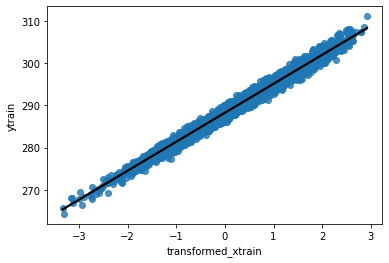

In [428]:
data = pd.DataFrame()
data['transformed_xtrain'] = transformed_xtrain.squeeze()
data['ytrain'] = ytrain['tasmax'].drop(['lat', 'lon']).to_dataframe()['tasmax'].values
sns.regplot(x='transformed_xtrain', y='ytrain', data=data, line_kws={"color": "k"})

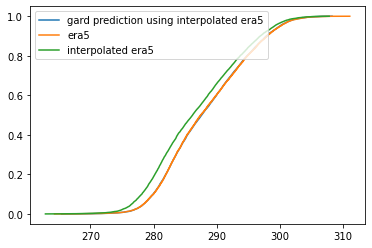

In [438]:
plot_cdf(
    ss_model.predict(transformed_xtrain)[:, 0], label='gard prediction using interpolated era5'
)
plot_cdf(ytrain['tasmax'], label='era5')
plot_cdf(xtrain['tasmax'], label='interpolated era5')

# and now let's try doing zscore in a gcm implementation

In [475]:
transformed_interpolated_era5 = dask.compute(
    bias_correct_obs_by_method(da_obs=xtrain, method='z_score', bc_kwargs={}).to_dataset(
        dim='variable'
    )
)[0]
transformed_gcm = dask.compute(
    bias_correct_gcm_by_method(
        gcm_hist=xtrain, gcm_pred=xpred, obs=xtrain, method='z_score', bc_kwargs={}
    ).to_dataset(dim='variable')
)[0]

In [ ]:
pr

In [ ]:
transformed_gcm.max()

<AxesSubplot:xlabel='transformed_gcm', ylabel='histgcm'>

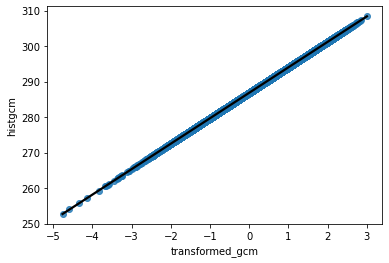

In [477]:
data = pd.DataFrame()
data['transformed_gcm'] = transformed_gcm['tasmax'].values
data['histgcm'] = xhist['tasmax'].values
sns.regplot(x='transformed_gcm', y='histgcm', data=data, line_kws={"color": "k"})

In [435]:
model = PointWiseDownscaler(
    model=get_gard_model(run_parameters['model_type'], run_parameters['model_params']), dim=dim
)

# model fitting
model.fit(
    transformed_interpolated_era5[run_parameters['variable']],
    ytrain.assign_coords({"time": transformed_obs_notebook.time.values})[
        run_parameters['variable']
    ],
)

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [437]:
out = model.predict(transformed_gcm[run_parameters['variable']]).to_dataset(dim='variable')
final_out = out['pred'] + scrf['scrf'] * out['prediction_error']

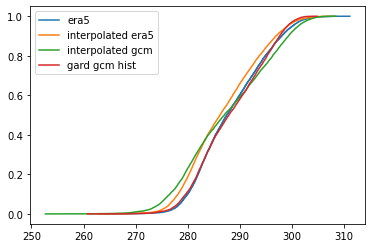

In [452]:
plot_cdf(ytrain['tasmax'], label='era5')
plot_cdf(xtrain['tasmax'], label='interpolated era5')
plot_cdf(xhist['tasmax'], label='interpolated gcm')
plot_cdf(out['pred'], label='gard gcm hist')

In [450]:
ytrain['tasmax'].quantile(0.99)

<xarray.DataArray 'tasmax' ()>
array(303.375)
Coordinates:
    quantile  float64 0.99

In [449]:
out['pred'].quantile(0.99)

<xarray.DataArray 'pred' ()>
array(301.32967285)
Coordinates:
    quantile  float64 0.99

In [451]:
final_out.quantile(0.99)

<xarray.DataArray ()>
array(301.44946167)
Coordinates:
    quantile  float64 0.99

In [457]:
xtrain = xr.open_zarr(xtrain_path).sel(**region).sel(**location).load()
ytrain = xr.open_zarr(ytrain_path).sel(**region).sel(**location).load()
xpred = xr.open_zarr(xpred_path).sel(**region).sel(**location).load()
xhist = xr.open_zarr(xhist_path).sel(**region).sel(**location).load()
scrf = read_scrf(run_parameters).sel(**region).sel(**location).load()

In [458]:
transformed_interpolated_era5 = dask.compute(
    bias_correct_obs_by_method(da_obs=xtrain, method='z_score', bc_kwargs={}).to_dataset(
        dim='variable'
    )
)[0]
transformed_gcm = dask.compute(
    bias_correct_gcm_by_method(
        gcm_hist=xhist, gcm_pred=xpred, obs=xtrain, method='z_score', bc_kwargs={}
    ).to_dataset(dim='variable')
)[0]

In [459]:
model = PointWiseDownscaler(
    model=get_gard_model(run_parameters['model_type'], run_parameters['model_params']), dim=dim
)

# model fitting
model.fit(
    transformed_interpolated_era5[run_parameters['variable']],
    ytrain.assign_coords({"time": transformed_obs_notebook.time.values})[
        run_parameters['variable']
    ],
)

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [460]:
out = model.predict(transformed_gcm[run_parameters['variable']]).to_dataset(dim='variable')
final_out = out['pred'] + scrf['scrf'] * out['prediction_error']

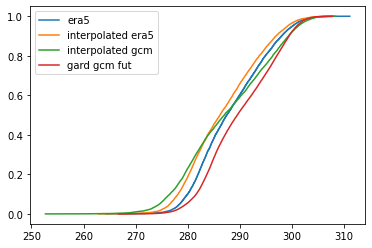

In [462]:
plot_cdf(ytrain['tasmax'], label='era5')
plot_cdf(xtrain['tasmax'], label='interpolated era5')
plot_cdf(xhist['tasmax'], label='interpolated gcm')

plot_cdf(out['pred'], label='gard gcm fut')

# let's try quantile mapping now to show how its behavior differs

for this one we'll go back to the pointwise downscsaler because it includes some nice features of extrapolating the cdf

# Things to try
* quantilemapper
* quantile mapper outside of bounds

In [204]:
# make sure you have the variables you need in obs
for v in xpred.data_vars:
    assert v in ytrain.data_vars

# _fit_wrapper(xtrain, ytrain)
# data transformation (this wants full-time chunking)
# transformed_obs is for the training period

# we need two transformed gcms - one for training and one for prediction
# for transformed gcm_train we pass the same thing as the training and the
# prediction since we're just transforming it
# Create a template dataset for map blocks
# This feals a bit fragile.
template_var = list(xpred.data_vars.keys())[0]
# .to_dataarray(dim='variable')
template_da = xpred[template_var]
template = xr.Dataset()
for var in ['pred', 'exceedance_prob', 'prediction_error']:
    template[var] = template_da

# Or you can use the wrappers

In [182]:
dim = 'time'

In [246]:
out = dask.compute(
    _fit_and_predict_wrapper(xtrain, ytrain, xpred.rename({'time': 't2'}), xpred, run_parameters)
)

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [247]:
(transformed_obs, transformed_gcm, model, prediction) = out[0]

In [176]:
transformed_obs_notebook = dask.compute(
    bias_correct_obs_by_method(
        da_obs=xtrain,
        method='quantile_transform',
        bc_kwargs={'output_distribution': 'normal', 'n_quantiles': len(xtrain.time)},
    ).to_dataset(dim='variable')
)[0]

In [213]:
# GCM historical

In [260]:
out = dask.compute(
    _fit_and_predict_wrapper(xtrain, ytrain, xpred.rename({'time': 't2'}), xpred, run_parameters)
)
(transformed_obs, transformed_gcm, model, prediction) = out[0]
final_out = prediction['pred'] + scrf['scrf'] * prediction['prediction_error']

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [261]:
regression = model._models.item()

In [292]:
gard_model.fit(transformed_xtrain.to_pandas(), ytrain['tasmax'].to_pandas())

PureRegression()

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


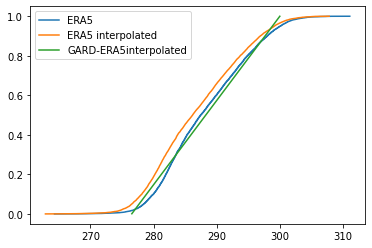

In [293]:
# in this case xhist and xpred are the same - downscaling historical gcm
# plot_cdf(xhist['tasmax'], label='GCM hist')
# plot_cdf(xpred['tasmax'], label='GCM pred')
plot_cdf(ytrain['tasmax'], label='ERA5')
plot_cdf(xtrain['tasmax'], label='ERA5 interpolated')
plot_cdf(gard_model.predict(transformed_xtrain)[:, 0], label='GARD-ERA5interpolated')
# plot_cdf(prediction['pred'], label='pred downscaled')
# plot_cdf(final_out, label='final downscaled')

# gut checks
- positive y intercept
- negative slope

In [ ]:
# GCM future

In [240]:
xtrain = xr.open_zarr(xtrain_path).sel(**region).sel(**location).load()
ytrain = xr.open_zarr(ytrain_path).sel(**region).sel(**location).load()
xpred = xr.open_zarr(xpred_path).sel(**region).sel(**location).load()
xhist = xr.open_zarr(xhist_path).sel(**region).sel(**location).load()
scrf = read_scrf(run_parameters).sel(**region).sel(**location).load()

In [242]:
out = dask.compute(
    _fit_and_predict_wrapper(xtrain, ytrain, xpred.rename({'time': 't2'}), xpred, run_parameters)
)
(transformed_obs, transformed_gcm, model, prediction) = out[0]
final_out = prediction['pred'] + scrf['scrf'] * prediction['prediction_error']

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


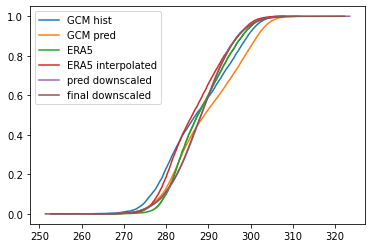

In [244]:
# in this case xhist and xpred are different
plot_cdf(xhist['tasmax'], label='GCM hist')
plot_cdf(xpred['tasmax'], label='GCM pred')
plot_cdf(ytrain['tasmax'], label='ERA5')
plot_cdf(xtrain['tasmax'], label='ERA5 interpolated')
plot_cdf(prediction['pred'], label='pred downscaled')
plot_cdf(final_out, label='final downscaled')

In [ ]:
bc_kwargs = {'output_distribution': 'normal', 'n_quantiles': len(xtrain.time)}
qt = PointWiseDownscaler(model=QuantileTransformer(**bc_kwargs), dim='time')
qt.fit(xtrain.sel(**location, method='nearest'))

In [177]:
transformed_gcm_notebook = dask.compute(
    bias_correct_gcm_by_method(
        gcm_hist=xhist,
        gcm_pred=xpred,
        obs=xtrain,
        method='quantile_transform',
        bc_kwargs={'output_distribution': 'normal', 'n_quantiles': len(xtrain.time)},
    ).to_dataset(dim='variable')
)[0]

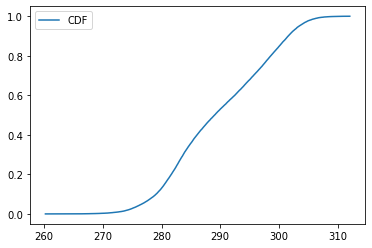

In [163]:
plot_cdf(xpred['tasmax'])

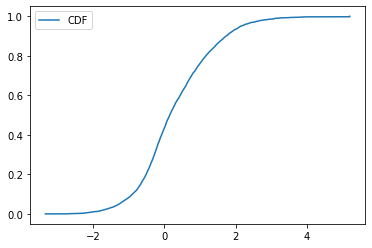

In [164]:
plot_cdf(transformed_gcm_notebook['tasmax'])

In [130]:
transformed_gcm_notebook['tasmax'].max().values

array(5.19933748)

In [178]:
model = PointWiseDownscaler(
    model=get_gard_model(run_parameters['model_type'], run_parameters['model_params']), dim=dim
)

In [ ]:
# model fitting
model.fit(
    transformed_obs_notebook[run_parameters['variable']],
    ytrain.assign_coords({"time": transformed_obs_notebook.time.values})[
        run_parameters['variable']
    ],
)

In [ ]:
# model prediction
out_notebook = model.predict(transformed_gcm_notebook[run_parameters['variable']]).to_dataset(
    dim='variable'
)

In [150]:
ytrain.max().values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float32 47.5
    lon      float32 -122.2
Data variables:
    tasmax   float64 311.1>

In [151]:
xtrain.max().values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float32 47.5
    lon      float32 -122.2
Data variables:
    tasmax   float64 307.8>

In [ ]:
final_out_notebook = out_notebook['pred'] + scrf['scrf'] * out_notebook['prediction_error']

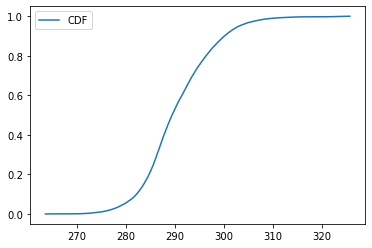

In [156]:
plot_cdf(final_out_notebook)

In [166]:
final_out_notebook.max().values

array(325.61694336)

In [168]:
(final_out_notebook > 322).sum()

<xarray.DataArray ()>
array(73)
Coordinates:
    lat      float32 47.5
    lon      float32 -122.2

In [170]:
out_notebook['prediction_error']

<xarray.DataArray 'prediction_error' (time: 31046)>
array([1.2239299, 1.2239299, 1.2239299, ..., 1.2239299, 1.2239299,
       1.2239299], dtype=float32)
Coordinates:
    lat      float32 47.5
    lon      float32 -122.2
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2099-12-31

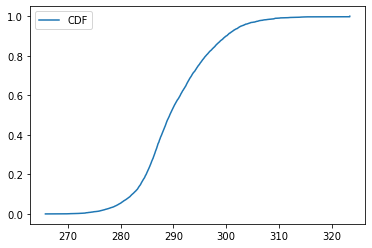

In [144]:
plot_cdf(out_notebook['pred'])

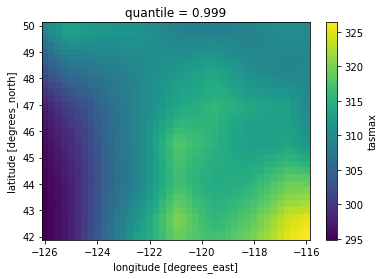

In [191]:
xpred.quantile(0.999, dim='time')['tasmax'].plot()

In [ ]:
# future gcm

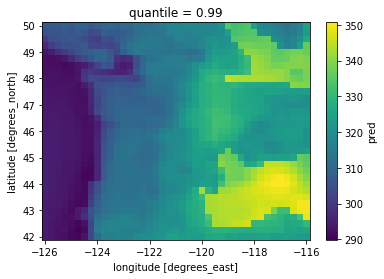

In [192]:
prediction.quantile(0.99, dim='time')['pred'].plot()

In [ ]:
# historical gcm

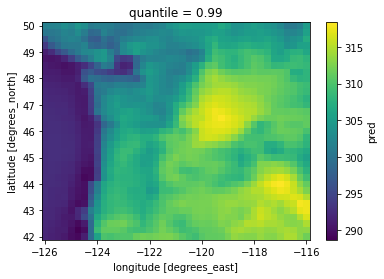

In [221]:
prediction.quantile(0.99, dim='time')['pred'].plot()

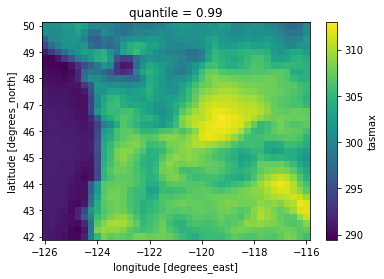

In [194]:
ytrain.quantile(0.99, dim='time')['tasmax'].plot()

In [58]:
bc_kwargs = {}
bc_kwargs['n_quantiles'] = len(xtrain.time)
qt = PointWiseDownscaler(model=QuantileTransformer(**bc_kwargs), dim='time')
qt.fit(xtrain.sel(**location, method='nearest'))

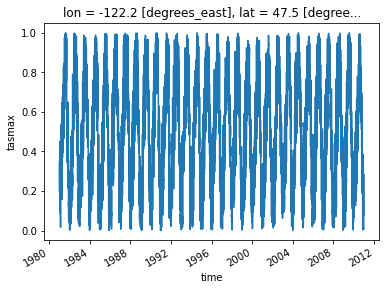

In [31]:
transformed_obs.sel(**location, method='nearest').tasmax.plot()

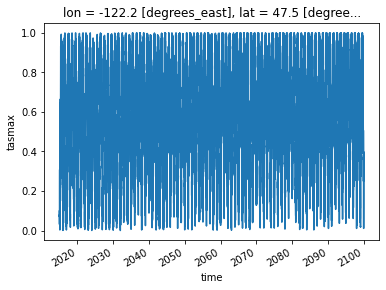

In [33]:
transformed_gcm.sel(**location, method='nearest').tasmax.plot()

In [41]:
scrf = read_scrf(run_parameters).sel(**region)

In [43]:
final_out = prediction['pred'] + scrf['scrf'] * prediction['prediction_error']

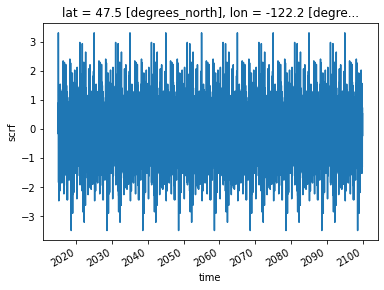

In [46]:
scrf.sel(**location, method='nearest').scrf.plot()

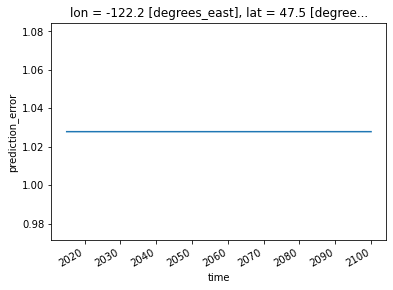

In [49]:
prediction['prediction_error'].sel(**location, method='nearest').plot()

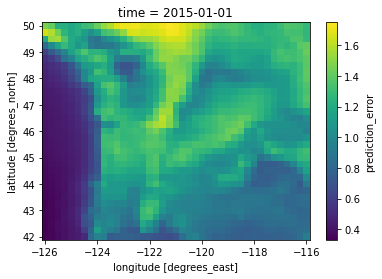

In [50]:
prediction['prediction_error'].isel(time=0).plot()

In [ ]:
# cdf plot of daily prediction
# try normal distribution in quantiletransformer - either use normal or detrend
# should the target also be quantiles

In [44]:
final_out.to_dataset(name='tasmax').sel(**location, method='nearest').max().tasmax.values

array(302.1955, dtype=float32)

In [54]:
ytrain.sel(lat=47.6, lon=-122.25, method='nearest').tasmax.max().values

array(311.0625, dtype=float32)

In [65]:
out.sel(lat=47.6, lon=-122.25, method='nearest').pred.max().values

AttributeError: 'DataArray' object has no attribute 'pred'

In [57]:
out

<xarray.Dataset>
Dimensions:           (time: 31046, lat: 33, lon: 41)
Coordinates:
  * time              (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2099-12-31
  * lon               (lon) float64 -126.0 -125.8 -125.5 ... -116.2 -116.0
  * lat               (lat) float64 42.0 42.25 42.5 42.75 ... 49.5 49.75 50.0
Data variables:
    pred              (time, lat, lon) float32 282.6 282.6 282.6 ... 270.6 273.1
    exceedance_prob   (time, lat, lon) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    prediction_error  (time, lat, lon) float32 0.3301 0.3495 ... 1.334 1.274

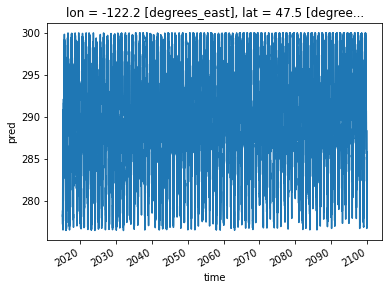

In [50]:
out.pred.sel(lat=47.6, lon=-122.25, method='nearest').plot()

In [79]:
out = xr.map_blocks(
    _fit_and_predict_wrapper,
    xtrain,
    args=(ytrain, xpred.rename({'time': 't2'}), run_parameters),
    kwargs={'dim': dim},
    template=template,
).compute()

/srv/conda/envs/notebook/lib/python3.9/site-packages/carbonplan_data/__init__.py:29: UserWarning: CARBONPLAN_DATA environment variable not set, `carbonplan.data.cat` may not work as expected.Known data locations include: ['https://storage.googleapis.com/carbonplan-data', 'https://carbonplan.blob.core.windows.net/carbonplan-data'].
  warnings.warn(msg)
/srv/conda/envs/notebook/lib/python3.9/site-packages/carbonplan_data/__init__.py:29: UserWarning: CARBONPLAN_DATA environment variable not set, `carbonplan.data.cat` may not work as expected.Known data locations include: ['https://storage.googleapis.com/carbonplan-data', 'https://carbonplan.blob.core.windows.net/carbonplan-data'].
  warnings.warn(msg)
/srv/conda/envs/notebook/lib/python3.9/site-packages/carbonplan_data/__init__.py:29: UserWarning: CARBONPLAN_DATA environment variable not set, `carbonplan.data.cat` may not work as expected.Known data locations include: ['https://storage.googleapis.com/carbonplan-data', 'https://carbonplan.

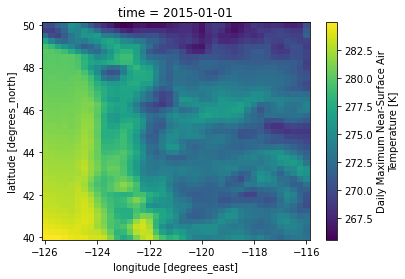

In [80]:
out.isel(time=0).pred.plot()

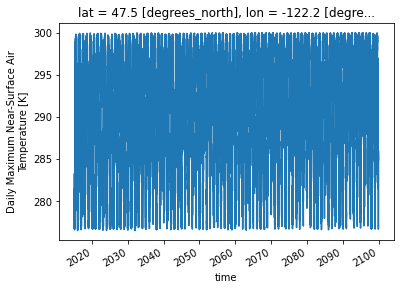

In [87]:
out.sel(lat=47.6, lon=-122.25, method='nearest').pred.plot()

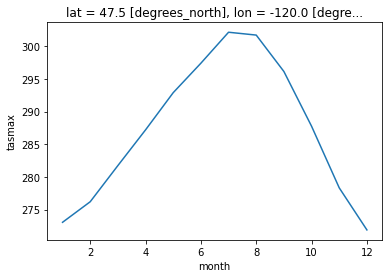

In [95]:
ytrain.tasmax.sel(lat=47.5, lon=-120, method='nearest').groupby('time.month').mean().plot(
    label='2030s'
)

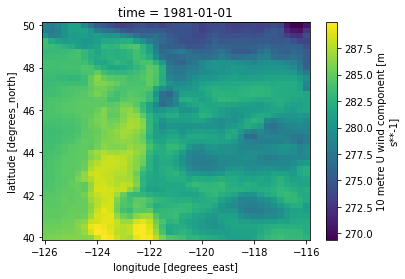

In [96]:
ytrain.isel(time=0).tasmax.plot()

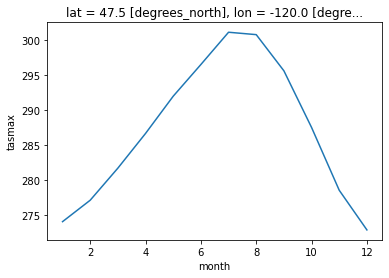

In [8]:
xtrain.tasmax.sel(lat=47.5, lon=-120, method='nearest').groupby('time.month').mean().plot(
    label='2030s'
)

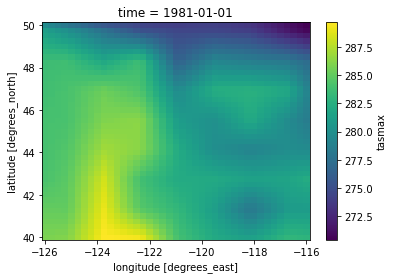

In [97]:
xtrain.isel(time=0).tasmax.plot()

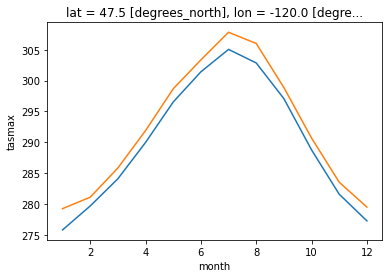

In [7]:
xpred.tasmax.sel(time=slice('2020', '2049')).sel(lat=47.5, lon=-120, method='nearest').groupby(
    'time.month'
).mean().plot(label='2030s')
xpred.tasmax.sel(time=slice('2070', '2099')).sel(lat=47.5, lon=-120, method='nearest').groupby(
    'time.month'
).mean().plot(label='2030s')

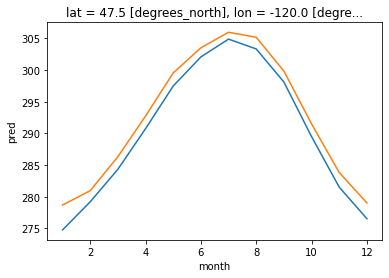

In [89]:
out.pred.sel(time=slice('2020', '2049')).sel(lat=47.5, lon=-120, method='nearest').groupby(
    'time.month'
).mean().plot(label='2030s')
out.pred.sel(time=slice('2070', '2099')).sel(lat=47.5, lon=-120, method='nearest').groupby(
    'time.month'
).mean().plot(label='2030s')

In [5]:
out = xr.open_zarr('az://flow-outputs/gard_test_result/0.0.post580+dirty/daily/e6ceccc3b6a4a077/')

In [104]:
out

,Array,Chunk
Bytes,120.08 GiB,272.87 MiB
Shape,"(31046, 721, 1440)","(31046, 48, 48)"
Count,481 Tasks,480 Chunks
Type,float32,numpy.ndarray


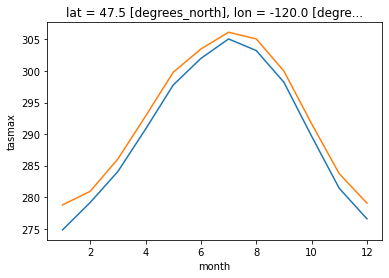

In [6]:
out.tasmax.sel(time=slice('2020', '2049')).sel(lat=47.5, lon=-120, method='nearest').groupby(
    'time.month'
).mean().plot(label='2030s')
out.tasmax.sel(time=slice('2070', '2099')).sel(lat=47.5, lon=-120, method='nearest').groupby(
    'time.month'
).mean().plot(label='2030s')

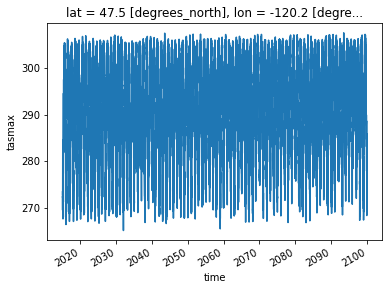

In [122]:
out.sel(lat=47.4, lon=-120.3, method='nearest').tasmax.plot()

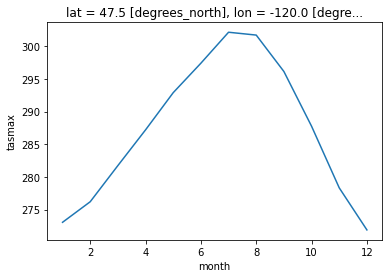

In [117]:
ytrain.sel(lat=47.5, lon=-120, method='nearest').groupby('time.month').mean().tasmax.plot()

In [110]:
print(
    out.tasmax.sel(time=slice('2020', '2039'))
    .sel(lat=47.5, lon=-120, method='nearest')
    .max()
    .values
)
print(
    out.tasmax.sel(time=slice('2080', '2099'))
    .sel(lat=47.5, lon=-120, method='nearest')
    .max()
    .values
)

308.77176
309.32727


In [11]:
client.restart()

NameError: name 'ds' is not defined

In [91]:
raw_scrf = xr.open_zarr('az://static/scrf/ERA5_tasmax_1981_1990.zarr')

In [92]:
scrf = (
    read_scrf(run_parameters=run_parameters)
    .drop('spatial_ref')
    .astype('float32')
    .chunk({'time': -1})
)

In [93]:
ds = xr.open_zarr('az://scratch/gard-test.zarr')

In [94]:
downscaled = ds['pred'] + scrf['scrf'].astype('float32') * ds['prediction_error']

In [95]:
downscaled_ds = dask.optimize(downscaled.to_dataset(name='tasmax'))[0]

In [96]:
downscaled_ds.to_zarr('az://scratch/gard-test-out.zarr', mode='w')

In [97]:
final = xr.open_zarr('az://scratch/gard-test-out.zarr')

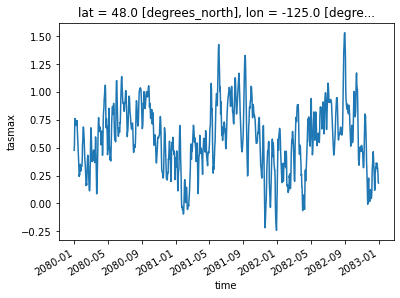

In [99]:
final.sel(lat=48, lon=-125, method='nearest').sel(time=slice('2080', '2082')).tasmax.plot()

In [70]:
downscaled_ds.chunks

Frozen({'time': (2190, 3652, 3652, 3652, 3652, 3652, 3652, 3652, 3292), 'lat': (48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 1), 'lon': (48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48)})

In [63]:
bcsd_result = xr.open_zarr(
    'az://flow-outputs/results/0.0.post527+dirty/bcsd_postprocess/6f33de8e2e834531/'
)

In [64]:
bcsd_result

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 31046)
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
    month    (time) int64 dask.array<chunksize=(31046,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2099-12-31
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(31046, 48, 48), meta=np.ndarray>
Attributes:
    history:        Created: Fri Apr  1 00:24:10 2022
    hostname:       jupyter-norlandrhagen--bcsd-5ffull
    institution:    CarbonPlan
    regrid_method:  bilinear
    source:         /srv/conda/envs/notebook/bin/prefect
    title:          bcsd_postprocess
    username:       norlandrhagen
    version:        0.0.post527+dirty

In [7]:
template_var = list(xpred.data_vars.keys())[0]
# .to_dataarray(dim='variable')
template_da = xpred[template_var]
template = xr.Dataset()
for var in ['pred', 'exceedance_prob', 'prediction_error']:
    template[var] = template_da

In [8]:
out = xr.map_blocks(
    _fit_and_predict_wrapper,
    xtrain,
    args=(ytrain, xpred.rename({'time': 't2'}), run_parameters),
    kwargs={'dim': 'time'},
    template=template,
)

In [9]:
out

,Array,Chunk
Bytes,120.08 GiB,272.87 MiB
Shape,"(31046, 721, 1440)","(31046, 48, 48)"
Count,6723 Tasks,480 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,120.08 GiB,272.87 MiB
Shape,"(31046, 721, 1440)","(31046, 48, 48)"
Count,6723 Tasks,480 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [10]:
# out = out.persist()


import dask

out = dask.optimize(out)[0]

In [11]:
%%time
future = out.to_zarr('az://scratch/gard-test2.zarr', mode='w', compute=False)
future.compute(retries=5)

/srv/conda/envs/notebook/lib/python3.9/site-packages/carbonplan_data/__init__.py:29: UserWarning: CARBONPLAN_DATA environment variable not set, `carbonplan.data.cat` may not work as expected.Known data locations include: ['https://storage.googleapis.com/carbonplan-data', 'https://carbonplan.blob.core.windows.net/carbonplan-data'].
  warnings.warn(msg)
/srv/conda/envs/notebook/lib/python3.9/site-packages/carbonplan_data/__init__.py:29: UserWarning: CARBONPLAN_DATA environment variable not set, `carbonplan.data.cat` may not work as expected.Known data locations include: ['https://storage.googleapis.com/carbonplan-data', 'https://carbonplan.blob.core.windows.net/carbonplan-data'].
  warnings.warn(msg)
/srv/conda/envs/notebook/lib/python3.9/site-packages/carbonplan_data/__init__.py:29: UserWarning: CARBONPLAN_DATA environment variable not set, `carbonplan.data.cat` may not work as expected.Known data locations include: ['https://storage.googleapis.com/carbonplan-data', 'https://carbonplan.

CPU times: user 14min 18s, sys: 1min 31s, total: 15min 49s
Wall time: 1h 14min 43s


In [12]:
ds = xr.open_zarr('az://scratch/gard-test2.zarr')

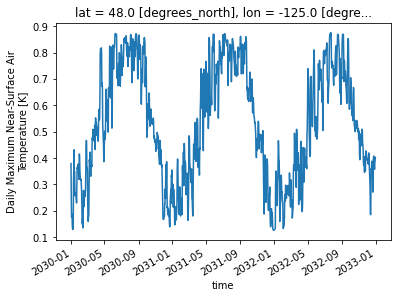

In [13]:
ds.sel(lat=48, lon=-125, method='nearest').sel(time=slice('2030', '2032')).pred.plot()

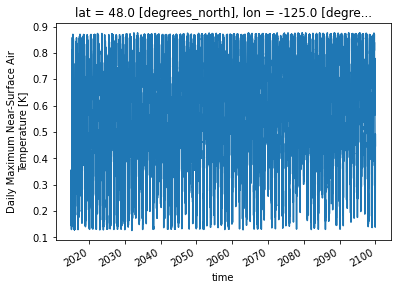

In [14]:
ds.sel(lat=48, lon=-125, method='nearest').pred.plot()

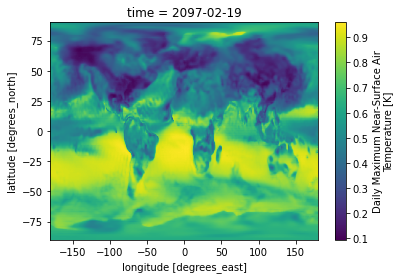

In [17]:
ds['pred'].isel(time=30000).plot()

In [16]:
print('here')

here


In [ ]:
out.to_zarr('az://scratch/junk.zarr')

In [ ]:
out

In [ ]:
out.attrs.update({'title': 'gard_fit_and_predict'}, **get_cf_global_attrs(version=version))
print(out)
# out = wait(out.persist())
t = out.to_zarr(target, mode='w')

In [ ]:
fs.rm('az://flow-outputs/gard_test_intermediate/0.0.post546+dirty/regrid', recursive=True)

In [ ]:
ds = xr.open_zarr(
    'az://flow-outputs/gard_test_intermediate/0.0.post546+dirty/regrid/fd0547ca98fa4fb2'
)

In [ ]:
ds.isel(time=40).tasmax.plot()

In [ ]:
fs.rm(
    'az://flow-outputs/gard_test_intermediate/0.0.post546+dirty/gard_fit_and_predict/a44a50638ca8c3ac/',
    recursive=True,
)

In [ ]:
ds = xr.open_zarr('az://flow-outputs/gard_test_result/0.0.post546+dirty/daily/800b9d58689bb76d')

In [ ]:
target = (intermediate_dir) / (
    UPath(
        str(
            "rechunk_"
            + pattern_string
            + '_'
            + str(path).split(str(intermediate_dir))[1].split('/')[-1]
        )
    )
)

In [ ]:
str(path).split(str(intermediate_dir))[1].split('/')[-1]

In [ ]:
print(target)

In [ ]:
testing = 'a'

In [ ]:
print('too bad {testing}')